xxx yolos

what do we need for yolo?
get all the labeld images?

transfrome labels?

weights?


In [1]:
from transformers import AutoModelForObjectDetection,AutoImageProcessor
from PIL import Image, ImageDraw
from functools import partial
from copy import deepcopy

import pandas as pd
import torch
import cv2 as cv
import numpy as np
import shutil
import os
import json


/home/jochen/Spiced/Capstone/kaggle_cryo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-base")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
img = Image.open("train/tomo_00e463/slice_0235.jpg")
test_img=image_processor(images=img, return_tensors="pt")


ValueError: Unsupported number of image dimensions: 2

In [5]:
ls

close_to_edge/            test_tomot_00e463_2.png
data/                     test_tomot_00e463_3.png
detr_finetuned_cppe5/     test_tomot_00e463_4.png
ersterlook.ipynb          test_tomot_00e463_5.png
Keggle_test/              test_tomot_00e463_6_ouput_normed.png
ouput_normed.png          test_tomot_00e463_6.png
output_yolo_transformer/  tomo_003acc.png
out_test2.jpg             tomo_00e047.png
out_test.jpg              tomo_00e463/
packages/                 tomo_01a877.png
predict_on_train_.ipynb   train/
random_predic/            Training_Yolo_transfomer.png
README.md                 train_labels.csv
rgb_test_img.jpg          ultralytics-for-offline-install/
sample_submission.csv     yolos_1.ipynb
slice_0169.jpg            yolos_base_finetuned_yolololos/
suitcase.png              yolos_transfomer_loss_580frame_57epoch_14batch.png
test_tomo_eb4fd4_1.png    yolosv3_epoche_120_520f_46bz.png
test_tomot_00e463_1.png


In [ ]:

outputs = model(**test_img)
#model.bbox_predictor(**test_img)

In [ ]:
target_sizes = torch.tensor([img.size[::-1]])

results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[

    0

]

In [ ]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection

grayscale_image = Image.open("tomo_00e463/slice_0235.jpg").convert("L")

# Convert to RGB
rgb_image = Image.merge("RGB", (grayscale_image, grayscale_image, grayscale_image))

# Save the RGB image
rgb_image.save("rgb_test_img.jpg")
img = Image.open("rgb_test_img.jpg")

feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-base')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-base')

inputs = feature_extractor(images=img, return_tensors="pt")
outputs = model(**inputs)

In [ ]:
logits = outputs.logits
bboxes = outputs.pred_boxes

In [ ]:
bboxes

In [ ]:
target_sizes = torch.tensor([[img.size[1], img.size[0]]])
results = image_processor.post_process_object_detection(outputs, threshold=0.005, target_sizes=target_sizes)[0]


In [ ]:
results

In [ ]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):

    box = [round(i, 2) for i in box.tolist()]

    print(

        f"Detected {model.config.id2label[label.item()]} with confidence "

        f"{round(score.item(), 3)} at location {box}"

    )

In [ ]:
draw = ImageDraw.Draw(img)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):

    box = [round(i, 2) for i in box.tolist()]

    x, y, x2, y2 = tuple(box)

    draw.rectangle((x, y, x2, y2), outline="red", width=1)

    draw.text((x, y), model.config.id2label[label.item()], fill="white")

img

---
## Fine Tune/ Transfer Modell

In [3]:
df=pd.read_csv("train_labels.csv")

In [43]:
df.head(2)

,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,0,tomo_003acc,-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1


In [ ]:
df["Voxel spacing"].value_counts()

In [ ]:
print(df[df["Motor axis 0"]!=-1]["Motor axis 0"].nsmallest(5))
print(df[df["Motor axis 1"]!=-1]["Motor axis 1"].nsmallest(5))
print(df[df["Motor axis 2"]!=-1]["Motor axis 2"].nsmallest(5))

In [ ]:
print(df["Array shape (axis 0)"].unique())
print(df["Array shape (axis 1)"].unique())
print(df["Array shape (axis 2)"].unique())

In [ ]:
#print(len(df[df["Array shape (axis 1)"]!=959]))
print(len(df[df["Array shape (axis 1)"]!=959]))
print(len(df[df["Array shape (axis 2)"]!=928]))

In [ ]:
print(len(df[df["Motor axis 0"]!=-1]))
print(len(df[df["Motor axis 1"]!=-1]))
print(len(df[df["Motor axis 2"]!=-1]))

In [ ]:
print(len(df[df["Motor axis 0"]!=-1]["tomo_id"].unique()))
print(len(df[df["Motor axis 1"]!=-1]["tomo_id"].unique()))
print(len(df[df["Motor axis 2"]!=-1]["tomo_id"].unique()))

In [ ]:
df[df["Motor axis 0"]==466]

In [ ]:
df[df["Motor axis 2"]!=-1]["Motor axis 2"].min()

In [46]:
(df["Number of motors"].value_counts())

Number of motors
1     313
0     286
2      56
4      36
6      18
3      18
10     10
Name: count, dtype: int64

In [4]:
list1 = [1, 2, 3, 4, 5]
list2 = [123, 234, 456]

lismit_ds={"d":{}}
lismit_ds["d"] = {'a': [], 'b': {"c":[]}}
lismit_ds["d"]['a'].append(list1)
lismit_ds["d"]['b']["c"].append(list2)
lismit_ds["b"]="fuuuu"
count_labl=0

print([*lismit_ds])
x=1
while x in [1,2,3,4,5]:
    if "h"  not in lismit_ds:
        lismit_ds["h"]={"file_name":f"{a[0]}/slice_{b:04d}.jpg",
                        'objects': {
                                    'id': [],
                                    'area': [],
                                    'bbox': [[0,3,5,2]],
                                    'category': []}
                        }
    else:
        lismit_ds["h"]["objects"]["bbox"].append([1,2,3,4])
        lismit_ds["h"]["objects"]["category"].append(0)
        lismit_ds["h"]["objects"]["area"].append(2*4)
        lismit_ds["h"]["objects"]["id"].append(count_labl)
    count_labl+=1
    x+=1

[*lismit_ds]

['d', 'b']


NameError: name 'a' is not defined

In [86]:
lst = [{'key':'key1','version':'1'},{'key':'key2','version':'2'},{'key':'key3','version':'3'}]
new_l = [{key: d[key] for key in d if key == 'key'} for d in lst]
print(new_l)

[{'key': 'key1'}, {'key': 'key2'}, {'key': 'key3'}]


In [ ]:
cppe5["train"][0]
{
  'image_id': 366,
  'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=500x290>,
  'objects': {
    'id': [1932, 1933, 1934],
    'area': [27063, 34200, 32431],
    'bbox': [[29.0, 11.0, 97.0, 279.0],
      [201.0, 1.0, 120.0, 285.0],
      [382.0, 0.0, 113.0, 287.0]],
    'category': [0, 0, 0]
  }
}

In [9]:
type(labels)

numpy.ndarray

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row_id                737 non-null    int64  
 1   tomo_id               737 non-null    object 
 2   Motor axis 0          737 non-null    float64
 3   Motor axis 1          737 non-null    float64
 4   Motor axis 2          737 non-null    float64
 5   Array shape (axis 0)  737 non-null    int64  
 6   Array shape (axis 1)  737 non-null    int64  
 7   Array shape (axis 2)  737 non-null    int64  
 8   Voxel spacing         737 non-null    float64
 9   Number of motors      737 non-null    int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 57.7+ KB


In [14]:
len(df[df["Number of motors"]>0]["tomo_id"].unique())

362

In [ ]:
tomot_with_motor_list=df[df["Number of motors"]>0]["tomo_id"].unique()


split = 0.15
size_det = len(tomot_with_motor_list)


test_split_len = int(size_det*split)


test_tomos = np.random.choice(tomot_with_motor_list, replace=False, size=test_split_len)

train_tomos=np.array([])

train_tomos=[np.append(train_tomos,tomo)for tomo in tomot_with_motor_list if tomo not in test_tomos]


308


In [49]:
df[(df["tomo_id"].isin(test_tomos))&(df["Number of motors"]>1)]

,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
2,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
3,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
4,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6
5,5,tomo_00e463,225.0,262.0,628.0,500,924,956,19.7,6
6,6,tomo_00e463,225.0,241.0,643.0,500,924,956,19.7,6
7,7,tomo_00e463,231.0,289.0,632.0,500,924,956,19.7,6
38,38,tomo_0de3ee,131.0,139.0,326.0,500,928,960,13.1,2
39,39,tomo_0de3ee,203.0,642.0,801.0,500,928,960,13.1,2
213,213,tomo_49725c,150.0,624.0,739.0,300,959,928,15.6,2
214,214,tomo_49725c,109.0,186.0,166.0,300,959,928,15.6,2


In [4]:
df_bbox=df.iloc[:,1:6]
labels=df_bbox.values
labels

array([['tomo_003acc', -1.0, -1.0, -1.0, 500],
       ['tomo_00e047', 169.0, 546.0, 603.0, 300],
       ['tomo_00e463', 235.0, 403.0, 137.0, 500],
       ...,
       ['tomo_fea6e8', -1.0, -1.0, -1.0, 300],
       ['tomo_ff505c', 111.0, 816.0, 678.0, 300],
       ['tomo_ff7c20', -1.0, -1.0, -1.0, 800]],
      shape=(737, 5), dtype=object)

In [ ]:
# Create YOLO format label
# YOLO format: <class> <x_center> <y_center> <width> <height>
# Values are normalized to [0, 1]
# {"file_name": "0001.png", "objects": {"bbox": [[302.0, 109.0, 73.0, 52.0]], "categories": [0]}}
BBOXS_SIZE = 70
detections = {}
detections_test = {}
detections_val= {}
trust = 2
rng = np.random.default_rng(42)
meta_train = []
meta_test = []
meta_val= []

size_empty = 3
source=[]
destination=[]
count_labl = 0

val_split= 0.1
test_split = 0.15

copy_files = True


tomot_with_motor_list=df[df["Number of motors"]>0]["tomo_id"].unique()


# test split

size_det = len(tomot_with_motor_list)

test_split_len = int(size_det*test_split)

test_tomos = np.random.choice(tomot_with_motor_list, replace=False, size=test_split_len)

train_tomos=[]

[train_tomos.append(tomo) for tomo in tomot_with_motor_list if tomo not in test_tomos]

print(train_tomos)
# Validation split

size_train = len(train_tomos)

val_split_len = int(size_train*val_split)

val_tomos = np.random.choice(train_tomos, replace=False, size=val_split_len)

train_tomos_new=[]

[train_tomos_new.append(tomo) for tomo in train_tomos if tomo not in val_tomos]

train_tomos=train_tomos_new


print(len(tomot_with_motor_list),len(train_tomos),len(test_tomos),len(val_tomos))


for a in labels:
    if a[1] != -1:
        for b in np.arange(int(a[1])-trust, int(a[1])+trust+1):
            if b < 0:
                continue
            width = float(BBOXS_SIZE)
            height = float(BBOXS_SIZE)
            if BBOXS_SIZE/2 > a[-2]:
                width = float((a[-2]-1)*2)
            if BBOXS_SIZE/2 > a[2]:
                height = float((a[2]-1)*2)

            image_name = f"{a[0]}/slice_{b:04d}"

            if a[0] in test_tomos:
            
                if image_name  not in detections_test:
                    detections_test[image_name]= {"file_name": f"{a[0]}/slice_{b:04d}.jpg", 
                                                        "objects": {"bbox": [[a[-2], a[2], width, height]], 
                                                                    "category": [0], 
                                                                    "id" : [count_labl], 
                                                                    "area":[width*height]
                                                                    }
                                                        }
                else:
                    detections_test[image_name]["objects"]["bbox"].append([a[-2], a[2], width, height])
                    detections_test[image_name]["objects"]["category"].append(0)
                    detections_test[image_name]["objects"]["id"].append(count_labl)
                    detections_test[image_name]["objects"]["area"].append(width*height)

            elif a[0] in train_tomos:
                if image_name  not in detections:
                    detections[image_name]= {"file_name": f"{a[0]}/slice_{b:04d}.jpg", 
                                                        "objects": {"bbox": [[a[-2], a[2], width, height]], 
                                                                    "category": [0], 
                                                                    "id" : [count_labl], 
                                                                    "area":[width*height]
                                                                    }
                                                        }
                else:
                    detections[image_name]["objects"]["bbox"].append([a[-2], a[2], width, height])
                    detections[image_name]["objects"]["category"].append(0)
                    detections[image_name]["objects"]["id"].append(count_labl)
                    detections[image_name]["objects"]["area"].append(width*height)

            elif a[0] in val_tomos:
                if image_name  not in detections_val:
                    detections_val[image_name]= {"file_name": f"{a[0]}/slice_{b:04d}.jpg", 
                                                        "objects": {"bbox": [[a[-2], a[2], width, height]], 
                                                                    "category": [0], 
                                                                    "id" : [count_labl], 
                                                                    "area":[width*height]
                                                                    }
                                                        }
                else:
                    detections_val[image_name]["objects"]["bbox"].append([a[-2], a[2], width, height])
                    detections_val[image_name]["objects"]["category"].append(0)
                    detections_val[image_name]["objects"]["id"].append(count_labl)
                    detections_val[image_name]["objects"]["area"].append(width*height)



# copy test files and make metadata file test

print(len(detections_val))

detection_list=list(detections.values())
detection_list_test=list(detections_test.values())
detection_list_val=list(detections_val.values())

key_list=[*detections]

for x, test in enumerate(detection_list_test):
    
    if test["objects"]["bbox"][0][1] >= 0:
        copy = deepcopy(test)
        source = "train/"+copy["file_name"]
        destination = "data/test/"+copy["file_name"].replace("/","_")
        
        if copy_files:
            if not os.path.isdir(os.path.dirname(destination)):
                os.mkdir(os.path.dirname(destination))

            shutil.copyfile(source, destination)
            
        copy["file_name"]=copy["file_name"].replace("/","_")
        image_id_split=key_list[x].replace("/","_").split("_")
        img_id=f"{int(image_id_split[1],16)}"+image_id_split[-1]
        meta_test.append({"image_id": img_id }|copy)
        copy=[]

for k, val in enumerate(detection_list_val):
    
    if val["objects"]["bbox"][0][1] >= 0:
        copy = deepcopy(val)
        source = "train/"+copy["file_name"]
        destination = "data/validation/"+copy["file_name"].replace("/","_")
        
        if copy_files:
            if not os.path.isdir(os.path.dirname(destination)):
                os.mkdir(os.path.dirname(destination))

            shutil.copyfile(source, destination)
            
        copy["file_name"]=copy["file_name"].replace("/","_")
        image_id_split=key_list[k].replace("/","_").split("_")
        img_id=f"{int(image_id_split[1],16)}"+image_id_split[-1]
        meta_val.append({"image_id": img_id }|copy)
        copy=[]

# collect train metadata.jason

for p, i in enumerate(detection_list):
    if i["objects"]["bbox"][0][1] >= 0:
        copy = deepcopy(i)
        source = "train/"+copy["file_name"]
        destination = "data/train/"+copy["file_name"].replace("/","_")

        if not os.path.isdir(os.path.dirname(destination)):
            os.mkdir(os.path.dirname(destination))

        shutil.copyfile(source, destination)
        copy["file_name"]=copy["file_name"].replace("/","_")
        
        #get unice image id
        image_id_split=key_list[p].replace("/","_").split("_")
        img_id=f"{int(image_id_split[1],16)}"+image_id_split[-1]
        
        meta_train.append({"image_id": img_id }|copy)
        copy=[]

# write to jason for hugginface
dest_path="train/"
if copy_files:
    dest_path="data/train/"
with open(dest_path+"metadata.jsonl", 'w') as jsonl_output:
    for entry in meta_train:
        json.dump(entry, jsonl_output)
        jsonl_output.write('\n')
        
if copy_files:
    dest_path="data/test/"
with open(dest_path+"metadata.jsonl", 'w') as jsonl_output:
    for entry in meta_test:
        json.dump(entry, jsonl_output)
        jsonl_output.write('\n')

if copy_files:
    dest_path="data/validation/"
with open(dest_path+"metadata.jsonl", 'w') as jsonl_output:
    for entry in meta_test:
        json.dump(entry, jsonl_output)
        jsonl_output.write('\n')


582 3305
0.17609682299546142
{'file_name': 'tomo_00e047/slice_0167.jpg', 'objects': {'bbox': [[638.0, 581.0, 70.0, 70.0]], 'category': [0], 'id': [0], 'area': [4900.0]}}


In [9]:
print(meta_train[9])

{'image_id': '584670240', 'file_name': 'tomo_00e463_slice_0240.jpg', 'objects': {'bbox': [[153.0, 363.0, 70.0, 70.0]], 'category': [0], 'id': [0], 'area': [4900.0]}}


In [10]:
from datasets import load_dataset
dataset=[]
# Load dataset
dataset = load_dataset("imagefolder", data_dir="data/")

#id2label = {0: "motor"}

Generating train split: 3305 examples [00:00, 6488.49 examples/s]
Generating test split: 582 examples [00:00, 7516.72 examples/s]


In [ ]:
if "validation" not in dataset:

    split = dataset["train"].train_test_split(0.1, seed=1337)

    dataset["train"] = split["train"]

    dataset["validation"] = split["test"]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'objects'],
        num_rows: 3057
    })
    test: Dataset({
        features: ['image_id', 'image', 'objects'],
        num_rows: 582
    })
    validation: Dataset({
        features: ['image_id', 'image', 'objects'],
        num_rows: 248
    })
})

In [19]:
dataset["test"][15]

{'image_id': '6919730052',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=928x959>,
 'objects': {'bbox': [[686.0, 349.0, 70.0, 70.0]],
  'category': [0],
  'id': [0],
  'area': [4900.0]}}

In [29]:
image = dataset["train"][2]["image"]

annotations = dataset["train"][2]["objects"]

annotations["bbox"][0]

[566.0, 114.0, 70.0, 70.0]

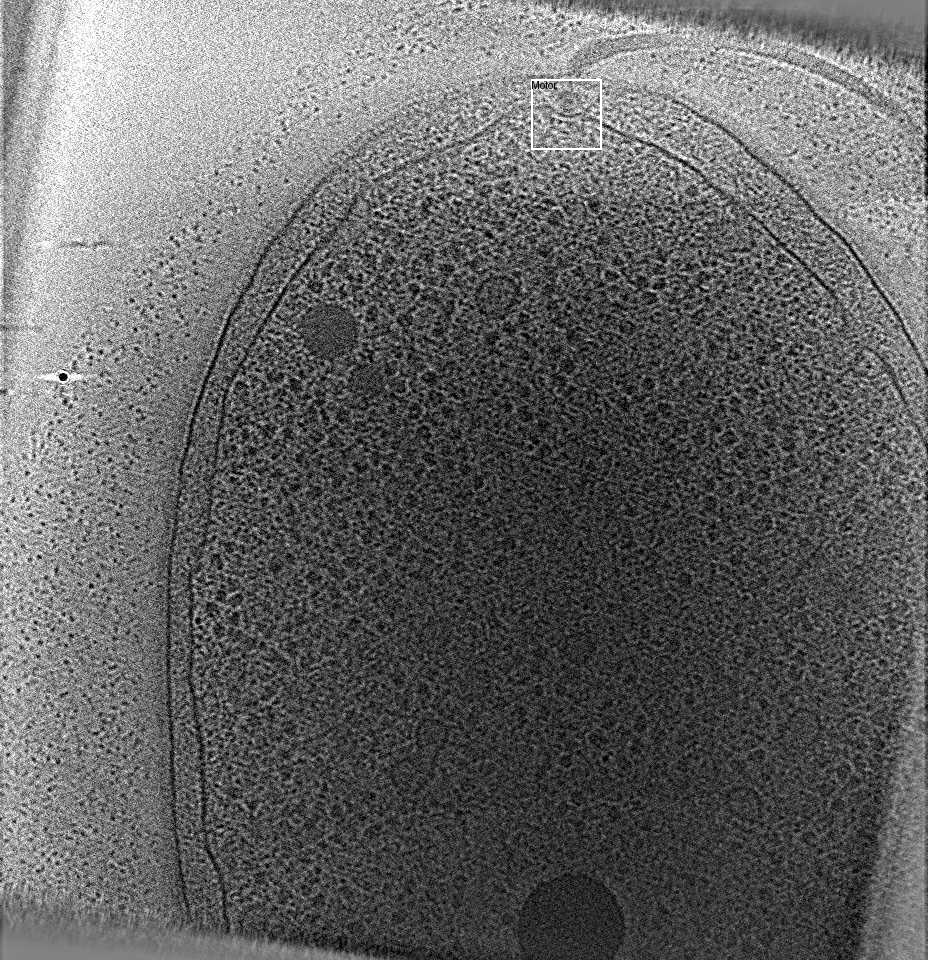

In [31]:
image = dataset["train"][2]["image"]

annotations = dataset["train"][2]["objects"]


draw = ImageDraw.Draw(image)

box = annotations["bbox"][0]

x, y, w, h = tuple(box)


draw.rectangle((x-w/2, y-h/2, x+w/2, y+h/2 ), outline="white", width=2)

draw.text((x-w/2, y-h/2), "Motor", fill="black")

image

In [34]:
MAX_SIZE= 460 

image_processor = AutoImageProcessor.from_pretrained(

    "hustvl/yolos-base",

    do_resize=True,

    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},

    do_pad=True,

    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},

)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import albumentations as A

train_augment_and_transform = A.Compose(

    [

        A.Perspective(p=0.1),

        A.HorizontalFlip(p=0.5),

        A.RandomBrightnessContrast(p=0.5),

        A.HueSaturationValue(p=0.1),

    ],

    bbox_params=A.BboxParams(format="coco", clip=True, min_area=25),

)

validation_transform = A.Compose(

    [A.NoOp()],

    bbox_params=A.BboxParams(format="coco", clip=True),

)


In [37]:

def format_image_annotations_as_coco(image_id, bboxes):

    """Format one set of image annotations to the COCO format

    Args:

        image_id (str): image id. e.g. "0001"

        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes

        areas (List[float]): list of corresponding areas to provided bounding boxes

        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format

            ([center_x, center_y, width, height] in absolute coordinates)

    Returns:

        dict: {

            "image_id": image id,

            "annotations": list of formatted annotations

        }

    """

    annotations = []

    for bbox in bboxes:

        formatted_annotation = {

            "image_id": image_id,

            "category_id": 0,

            "iscrowd": 0,

            "area": 0,

            "bbox": list(bbox),

        }

        annotations.append(formatted_annotation)

    return {

        "image_id": image_id,

        "annotations": annotations,

    }

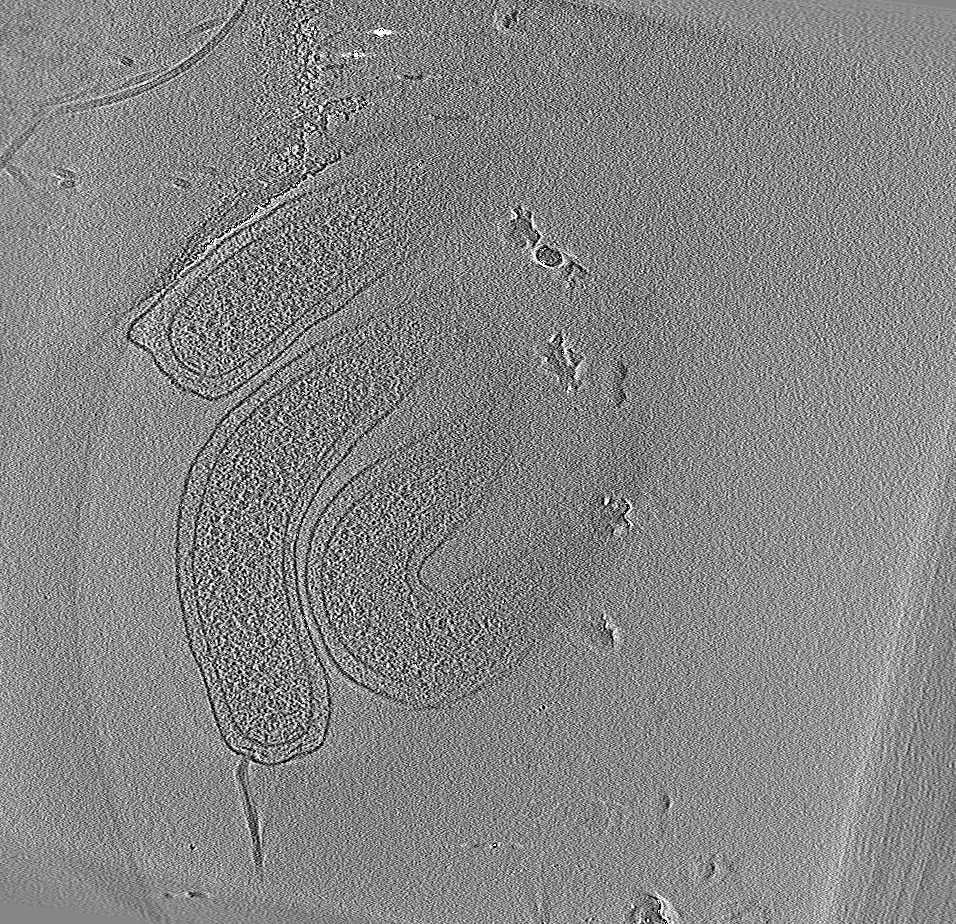

In [39]:
dataset["train"][2]["image"]

In [40]:
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):

    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []

    annotations = []

    for image, objects in zip(examples["image"], examples["objects"]):

        image = np.array(image.convert("RGB"))

        # apply augmentations

        output = transform(image=image, bboxes=objects["bbox"], category=objects["categories"])

        images.append(output["image"])

        # format annotations in COCO format

        formatted_annotations = format_image_annotations_as_coco(

            image, output["bboxes"]

        )

        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization

    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:

        result.pop("pixel_mask", None)

    return result

In [41]:
train_transform_batch = partial(

    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor

)

validation_transform_batch = partial(

    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor

)

dataset["train"] = dataset["train"].with_transform(train_transform_batch)

dataset["validation"] = dataset["validation"].with_transform(validation_transform_batch)

dataset["test"] = dataset["test"].with_transform(validation_transform_batch)

dataset["train"][15]

KeyError: 'categories'

In [7]:
from transformers.image_transforms import center_to_corners_format

def convert_bbox_yolo_to_pascal(boxes, image_size):

    """

    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]

    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:

        boxes (torch.Tensor): Bounding boxes in YOLO format

        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:

        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)

    """

    # convert center to corners format
    print(boxes)

    boxes = center_to_corners_format(boxes)
    print(boxes)
    # convert to absolute coordinates

    height, width = image_size

    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [8]:
from dataclasses import dataclass

from torchmetrics.detection.mean_ap import MeanAveragePrecision
id2label = {0: "Motor"}
label2id = {"motor":0}
@dataclass

class ModelOutput:

    logits: torch.Tensor

    pred_boxes: torch.Tensor


@torch.no_grad()

def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):

    """

    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:

        evaluation_results (EvalPrediction): Predictions and targets from evaluation.

        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.

        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:

        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}

    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:

    #  - targets in a form of list of dictionaries with keys "boxes", "labels"

    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []

    post_processed_targets = []

    post_processed_predictions = []

    # Collect targets in the required format for metric computation

    for batch in targets:

        # collect image sizes, we will need them for predictions post processing

        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))

        image_sizes.append(batch_image_sizes)

        # collect targets in the required format for metric computation

        # boxes were converted to YOLO format needed for model training

        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)

        for image_target in batch:

            boxes = torch.tensor(image_target["boxes"])

            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])

            labels = torch.tensor(image_target["class_labels"])

            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,

    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format

    for batch, target_sizes in zip(predictions, image_sizes):

        batch_logits, batch_boxes = batch[1], batch[2]

        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))

        post_processed_output = image_processor.post_process_object_detection(

            output, threshold=threshold, target_sizes=target_sizes

        )

        post_processed_predictions.extend(post_processed_output)

    # Compute metrics

    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)

    metric.update(post_processed_predictions, post_processed_targets)

    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class

    classes = metrics.pop("classes")

    map_per_class = metrics.pop("map_per_class")

    mar_100_per_class = metrics.pop("mar_100_per_class")

    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):

        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()

        metrics[f"map_{class_name}"] = class_map

        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(

    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0

)

NameError: name 'image_processor' is not defined

In [16]:
def collate_fn(batch):

    data = {}

    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])

    data["labels"] = [x["labels"] for x in batch]

    if "pixel_mask" in batch[0]:

        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])

    return data

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(

    output_dir="yolos_base_finetuned_yolololos",

    num_train_epochs=30,

    fp16=False,

    per_device_train_batch_size=8,

    gradient_accumulation_steps=4,

    dataloader_num_workers=4,

    learning_rate=5e-5,

    lr_scheduler_type="cosine",

    weight_decay=1e-4,

    max_grad_norm=0.01,

    metric_for_best_model="eval_map",

    greater_is_better=True,

    load_best_model_at_end=True,

    eval_strategy="epoch",

    save_strategy="epoch",

    save_total_limit=2,

    remove_unused_columns=False,

    eval_do_concat_batches=False,

    push_to_hub=False,

)

In [18]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(

    "hustvl/yolos-base",

    id2label=id2label,

    label2id=label2id,

    ignore_mismatched_sizes=True,

)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-base and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

trainer = Trainer(

    model=model,
)

trainer.train()

In [ ]:


tensor([[928, 928],
        [959, 928],
        [928, 960],
        [928, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [928, 928]])
tensor([[928, 928],
        [959, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [960, 928]])
tensor([[959, 928],
        [928, 928],
        [924, 956],
        [960, 928],
        [960, 928],
        [959, 928],
        [960, 928],
        [960, 928]])
tensor([[924, 956],
        [959, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [928, 960],
        [959, 928],
        [928, 928]])
tensor([[924, 956],
        [960, 928],
        [960, 928],
        [959, 928],
        [924, 956],
        [924, 956],
        [959, 928],
        [960, 928]])
tensor([[960, 928],
        [960, 928],
        [928, 928],
        [960, 928],
        [924, 956],
        [924, 956],
        [928, 960],
        [960, 928]])
tensor([[959, 928],
        [960, 928],
        [959, 928],
        [959, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [928, 928]])
tensor([[959, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [928, 960]])
tensor([[928, 960],
        [960, 928],
        [960, 928],
        [959, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [960, 928]])
tensor([[959, 928],
        [960, 928],
        [959, 928],
        [959, 928],
        [924, 956],
        [960, 928],
        [959, 928],
        [928, 960]])
tensor([[960, 928],
        [928, 928],
        [959, 928],
        [959, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [928, 960]])
tensor([[924, 956],
        [960, 928],
        [924, 956],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928]])
tensor([[960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [959, 928],
        [960, 928]])
tensor([[960, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [960, 928],
        [928, 960],
        [960, 928],
        [924, 956]])
tensor([[928, 960],
        [960, 928],
        [924, 956],
        [959, 928],
        [924, 956],
        [928, 928],
        [960, 928],
        [924, 956]])
tensor([[959, 928],
        [924, 956],
        [960, 928],
        [924, 956],
        [960, 928],
        [924, 956],
        [960, 928],
        [960, 928]])
tensor([[924, 956],
        [928, 960],
        [960, 928],
        [960, 928],
        [960, 928],
        [928, 928],
        [928, 928],
        [960, 928]])
tensor([[959, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [928, 928],
        [928, 928],
        [924, 956],
        [959, 928]])
tensor([[960, 928],
        [928, 928],
        [928, 960],
        [959, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928]])
tensor([[959, 928],
        [924, 956],
        [959, 928],
        [924, 956],
        [960, 928],
        [924, 956],
        [924, 956],
        [924, 956]])
tensor([[960, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [959, 928],
        [960, 928],
        [960, 928]])
tensor([[924, 956],
        [928, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [959, 928],
        [960, 928],
        [928, 960]])
tensor([[928, 960],
        [928, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [924, 956],
        [928, 960]])
tensor([[960, 928],
        [960, 928],
        [960, 928],
        [928, 960],
        [959, 928],
        [924, 956],
        [960, 928],
        [960, 928]])
tensor([[960, 928],
        [928, 960],
        [960, 928],
        [960, 928],
        [928, 960],
        [928, 928],
        [960, 928],
        [960, 928]])
tensor([[960, 928],
        [928, 928],
        [960, 928],
        [960, 928],
        [928, 960],
        [924, 956],
        [960, 928],
        [960, 928]])
tensor([[959, 928],
        [959, 928],
        [959, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [959, 928],
        [924, 956]])
tensor([[960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [959, 928],
        [960, 928]])
tensor([[924, 956],
        [960, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [959, 928],
        [960, 928],
        [960, 928]])
tensor([[928, 960],
        [960, 928],
        [960, 928],
        [924, 956],
        [960, 928],
        [928, 928],
        [928, 928],
        [928, 960]])
tensor([[924, 956],
        [924, 956],
        [960, 928],
        [959, 928],
        [960, 928],
        [924, 956],
        [924, 956],
        [960, 928]])
tensor([[960, 928],
        [928, 960],
        [960, 928],
        [959, 928],
        [928, 960],
        [928, 960],
        [960, 928],
        [924, 956]])
tensor([[960, 928],
        [959, 928],
        [928, 928],
        [959, 928],
        [924, 956],
        [924, 956],
        [960, 928],
        [928, 928]])
tensor([[924, 956],
        [928, 960],
        [959, 928],
        [960, 928],
        [928, 928],
        [960, 928],
        [960, 928],
        [960, 928]])
tensor([[928, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [924, 956],
        [959, 928],
        [928, 960]])
tensor([[959, 928],
        [960, 928],
        [960, 928],
        [924, 956],
        [924, 956],
        [928, 960],
        [924, 956],
        [928, 928]])
tensor([[924, 956],
        [960, 928],
        [924, 956],
        [960, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [928, 960]])
tensor([[960, 928],
        [960, 928],
        [960, 928],
        [960, 928],
        [959, 928],
        [960, 928],
        [960, 928],
        [928, 928]])
tensor([[924]])
